# Statistical inference over human and model behavioral performance

**The purpose of this notebook is to:** 
* Visualize human and model prediction accuracy (proportion correct)
* Visualize average-human and model agreement (RMSE)
* Visualize human-human and model-human agreement (Cohen's kappa)
* Compare performance between models

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)
* Running `./summarize_human_model_behavior.ipynb` (PUBLIC USE)

### Load packages

In [1]:
suppressMessages(suppressWarnings(suppressPackageStartupMessages({library(tidyverse)
library(ggthemes)
library(lme4)
library(lmerTest)
library(brms)
library(broom.mixed)
library(tidyboot)                
require('MuMIn')
})))

In [2]:
A = read_csv('../results/csv/summary/model_human_accuracies.csv')
# A = read_csv('../results/csv/models/allModels_results.csv')
AH = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')
K = read_csv('../results/csv/summary/model_human_CohensK.csv')

## preprocessing
A <- A %>%
    dplyr::rename('model_kind'='Model Kind', 
                  'encoder_training_dataset_type'='Encoder Training Dataset Type',
                  'dynamics_training_dataset_type'='Dynamics Training Dataset Type',
                  'readout_training_data_type'='Readout Train Data Type', 
                  'readout_type'='Readout Type',
                  'visual_encoder_architecture' = 'Visual encoder architecture',
                  'dynamics_model_architecture' = 'Dynamics model architecture') %>%
    left_join(AH, by='scenario') %>% 
    group_by(model_kind) %>%
    mutate(avg_model_correct = mean(model_correct))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ratio = col_double(),
  diff = col_double(),
  human_correct = col_double(),
  model_correct = col_double(),
  `Encoder Pre-training Seed` = col_logical(),
  `Encoder Training Seed` = col_double(),
  `Dynamics Training Seed` = col_double(),
  ObjectCentric = col_logical(),
  Supervised = col_logical(),
  SelfSupervisedLossSelfSupervisedLoss = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  Cohens_k_lb = col_double(),
  Cohens_k_med

## Visualize human and model prediction accuracy (proportion correct)


── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)




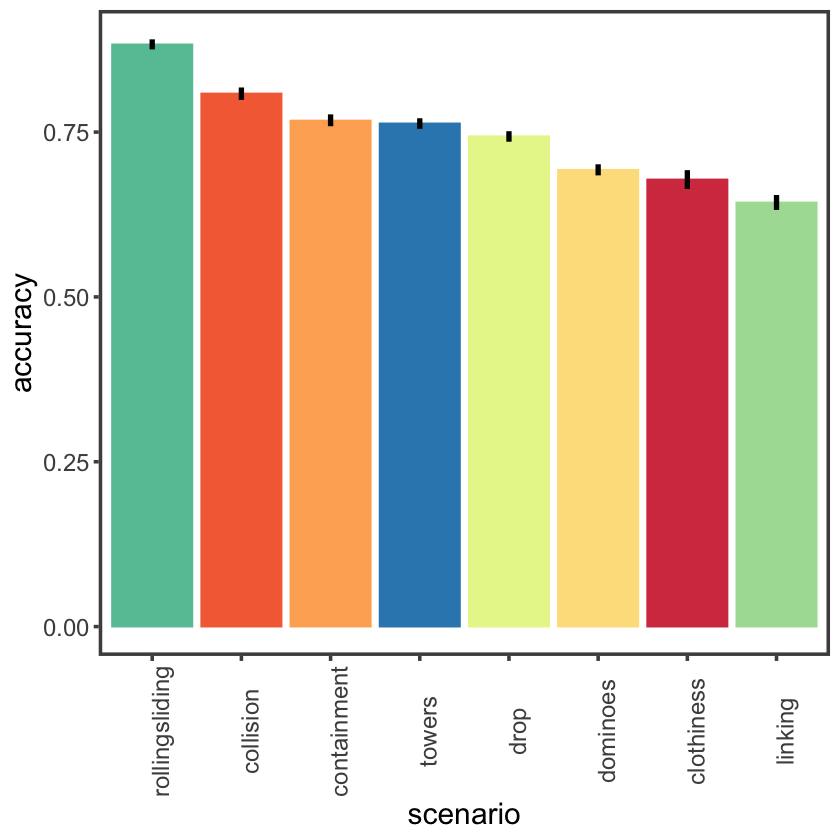

In [3]:
## human accuracy only
d = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')

## accuracy bar plot with 95% CIs
d %>%
  ggplot(aes(x=reorder(scenario,-obs_mean), y=obs_mean, color=scenario, fill=scenario)) +
  geom_bar(stat='identity') +
  geom_errorbar(aes(ymin=ci_lb, ymax = ci_ub), width = 0, size = 1.5, color='black') + 
    theme_few() +
    xlab('scenario') +
    ylab('accuracy') +
    theme(text = element_text(size=18), 
          element_line(size=1), 
          element_rect(size=2, color="#00000"),
          axis.text.x = element_text(angle=90)) +
    theme(legend.position = "none") +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_accuracy_across_scenarios.pdf', width=12, height = 18, units='cm')

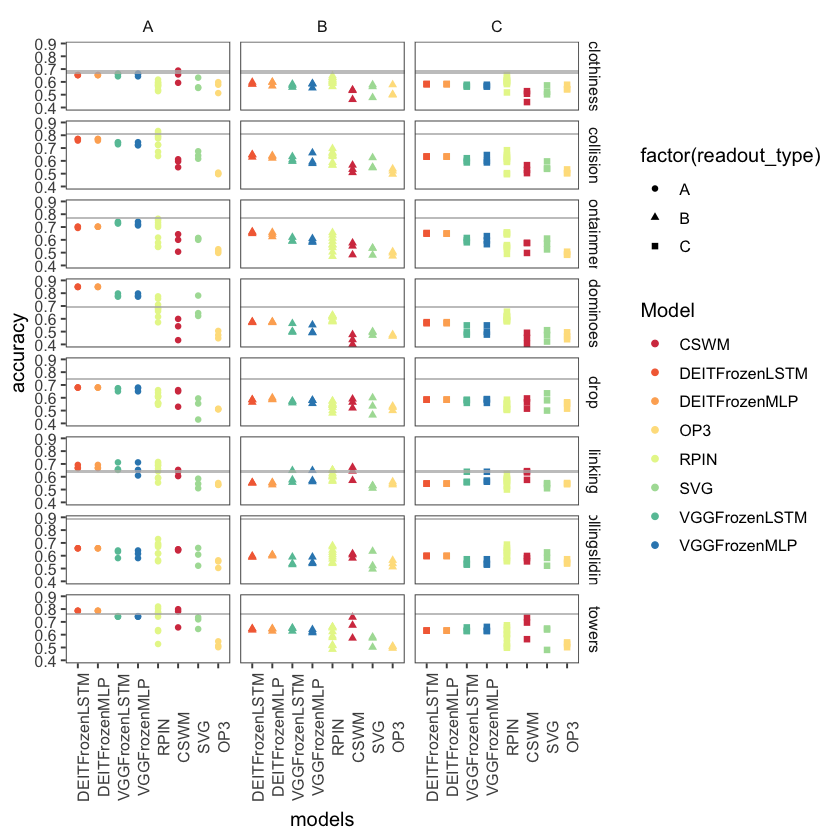

In [4]:
## human model accuracy comparison
A %>%
    filter(readout_type %in% c('A','B','C')) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(readout_type))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
    #geom_hline(aes(yintercept = human_correct)) +
    geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
    facet_grid(rows=vars(scenario), cols=vars(readout_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios.pdf', width=36, height = 36, units='cm')

## Visualize average-human and model agreement (RMSE)

In [5]:
## TODO

## Visualize human-human and model-human agreement (Cohen's kappa)

In [6]:
## TODO

## Comparing performance between models

* Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
* Comparison 2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)
* Comparison 3: Among unsupervised models, object-centric vs. non-object-centric
        * {CSWM, OP3} vs. {SVG}
* Comparison 4: Latent vs. pixel reconstruction loss
        * CSWM vs. OP3
* Comparison 5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

Dimensions: 
* “Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
* “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
* “ObjectCentric”: [TRUE, FALSE, NA]
* “Supervised”: [TRUE, FALSE]
* “SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]


## Q1: Visual encoder architecture (ConvNet vs. transformer)

In [7]:
## Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
Q1 <- A %>% 
        filter(visual_encoder_architecture %in% c('ConvNet','Transformer')) %>%
        filter(readout_type %in% c('A','B','C')) 

In [8]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type), data=Q1)
M1 <- lmer(model_correct ~ visual_encoder_architecture + (1 | scenario)  + (1 | readout_type), data=Q1)
summary(M1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ visual_encoder_architecture + (1 | scenario) +  
    (1 | readout_type)
   Data: Q1

REML criterion at convergence: -1169.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2307 -0.4879 -0.0974  0.4200  3.3708 

Random effects:
 Groups       Name        Variance  Std.Dev.
 scenario     (Intercept) 0.0008507 0.02917 
 readout_type (Intercept) 0.0039773 0.06307 
 Residual                 0.0019865 0.04457 
Number of obs: 360, groups:  scenario, 8; readout_type, 3

Fixed effects:
                                        Estimate Std. Error        df t value
(Intercept)                            5.652e-01  3.821e-02 2.400e+00   14.79
visual_encoder_architectureTransformer 6.541e-02  5.873e-03 3.490e+02   11.14
                                       Pr(>|t|)    
(Intercept)                             0.00205 ** 
visual_encoder_architectureTransformer  < 2e-16 ***
--

Transformer architectures outperform convnet architectures.

In [9]:
## model comparison relative to null model
anova(M0,M1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-1068.187,-1052.643,538.0936,-1076.187,NA,NA,NA
M1,5,-1172.647,-1153.216,591.3233,-1182.647,106.4594,1,5.847931e-25


Model containing `visual_encoder_architecture` as a predictor outperforms null model without it .

In [10]:
## explained variance
r.squaredGLMM(M1)

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


R2m,R2c
0.09152729,0.7351669


Showing that your marginal R squared is 0.09 and your conditional R squared is 0.74. 

### Transformer architecture outperforms ConvNet architecture: $b=0.0654,t(349)=11.14, p=0.002$

## Q2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)

In [12]:
## Comparison 2
Q2 <- A %>% 
        filter(dynamics_model_architecture %in% c('LSTM','MLP')) %>%
        mutate(dynamics_model_architecture = factor(dynamics_model_architecture)) %>%
        filter(readout_type %in% c('A','B','C'))   

In [13]:
Q2 %>% 
    group_by(dynamics_model_architecture, Model) %>%
    summarise(mean(model_correct))

`summarise()` has grouped output by 'dynamics_model_architecture'. You can override using the `.groups` argument.



dynamics_model_architecture,Model,mean(model_correct)
<fct>,<chr>,<dbl>
LSTM,DEITFrozenLSTM,0.6414327
LSTM,VGGFrozenLSTM,0.6206286
MLP,DEITFrozenMLP,0.6411965
MLP,VGGFrozenMLP,0.6191530


In [14]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type), data=Q2)
M2 <- lmer(model_correct ~ dynamics_model_architecture + (1 | scenario) + (1 | readout_type), data=Q2)
summary(M2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ dynamics_model_architecture + (1 | scenario) +  
    (1 | readout_type)
   Data: Q2

REML criterion at convergence: -1001.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9770 -0.5065 -0.1024  0.4520  3.5912 

Random effects:
 Groups       Name        Variance  Std.Dev.
 scenario     (Intercept) 0.0009856 0.03139 
 readout_type (Intercept) 0.0047602 0.06899 
 Residual                 0.0015139 0.03891 
Number of obs: 288, groups:  scenario, 8; readout_type, 3

Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                     6.310e-01  4.148e-02  2.332e+00  15.213
dynamics_model_architectureMLP -8.559e-04  4.586e-03  2.770e+02  -0.187
                               Pr(>|t|)   
(Intercept)                     0.00219 **
dynamics_model_architectureMLP  0.85207   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

### Recurrence (LSTM) does not outperform MLP: $b=-8.559e-04 ,t(277)=-0.187, p=0.852$

In [15]:
anova(M0,M2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-1007.256,-992.6038,507.6278,-1015.256,NA,NA,NA
M2,5,-1005.291,-986.9758,507.6453,-1015.291,0.03496107,1,0.8516773


In [16]:
## explained variance
r.squaredGLMM(M2)

R2m,R2c
2.531293e-05,0.791469


## Q3:  Among unsupervised models, object-centric vs. non-object-centric
{CSWM, OP3} vs. {SVG}

In [17]:
A$Model

[1] "CSWM"           "CSWM"           "CSWM"           "CSWM"          
  [5] "CSWM"           "CSWM"           "CSWM"           "CSWM"          
  [9] "CSWM"           "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM"
 [13] "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM"
 [17] "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenMLP"  "DEITFrozenMLP" 
 [21] "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP" 
 [25] "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP"  "OP3"           
 [29] "OP3"            "OP3"            "OP3"            "OP3"           
 [33] "OP3"            "OP3"            "OP3"            "OP3"           
 [37] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [41] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [45] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [49] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [53] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [57] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [61] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [65] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [69] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
 [73] "SVG"            "SVG"            "SVG"            "SVG"           
 [77] "SVG"            "SVG"            "SVG"            "SVG"           
 [81] "SVG"            "SVG"            "SVG"            "SVG"           
 [85] "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM" 
 [89] "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM" 
 [93] "VGGFrozenLSTM"  "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"  
 [97] "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"  
[101] "VGGFrozenMLP"   "VGGFrozenMLP"   "CSWM"           "CSWM"          
[105] "CSWM"           "CSWM"           "CSWM"           "CSWM"          
[109] "CSWM"           "CSWM"           "CSWM"           "DEITFrozenLSTM"
[113] "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM"
[117] "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM"
[121] "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP" 
[125] "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP"  "DEITFrozenMLP" 
[129] "DEITFrozenMLP"  "OP3"            "OP3"            "OP3"           
[133] "OP3"            "OP3"            "OP3"            "OP3"           
[137] "OP3"            "OP3"            "RPIN"           "RPIN"          
[141] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[145] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[149] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[153] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[157] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[161] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[165] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[169] "RPIN"           "RPIN"           "RPIN"           "RPIN"          
[173] "RPIN"           "RPIN"           "SVG"            "SVG"           
[177] "SVG"            "SVG"            "SVG"            "SVG"           
[181] "SVG"            "SVG"            "SVG"            "SVG"           
[185] "SVG"            "SVG"            "VGGFrozenLSTM"  "VGGFrozenLSTM" 
[189] "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM" 
[193] "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenLSTM"  "VGGFrozenMLP"  
[197] "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"  
[201] "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"   "VGGFrozenMLP"  
[205] "CSWM"           "CSWM"           "CSWM"           "CSWM"          
[209] "CSWM"           "CSWM"           "CSWM"           "CSWM"          
[213] "CSWM"           "DEITFrozenLSTM" "DEITFrozenLSTM" "DEITFrozenLSTM"
[217] 

In [18]:
## Comparison 3
Q3 <- A %>% 
        filter(Supervised==FALSE) %>%
        filter(ObjectCentric %in% c(TRUE,FALSE)) %>%
        filter(readout_type %in% c('A','B','C'))   

In [19]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type), data=Q3)
M3 <- lmer(model_correct ~ ObjectCentric + (1 | scenario) + (1 | readout_type), data=Q3)
summary(M3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ ObjectCentric + (1 | scenario) + (1 | readout_type)
   Data: Q3

REML criterion at convergence: -570.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6451 -0.6358 -0.0724  0.5777  4.0144 

Random effects:
 Groups       Name        Variance  Std.Dev.
 scenario     (Intercept) 0.0008891 0.02982 
 readout_type (Intercept) 0.0006432 0.02536 
 Residual                 0.0035651 0.05971 
Number of obs: 216, groups:  scenario, 8; readout_type, 3

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.565189   0.019366   4.852803  29.184 1.22e-06 ***
ObjectCentricTRUE  -0.015754   0.008618 204.999984  -1.828    0.069 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ObjctCnTRUE -0.297

### Weak effect of ObjectCentric representations: $b=-0.0158 ,t(205)=-1.828, p=0.069$

In [20]:
anova(M0,M3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-572.6716,-559.1704,290.3358,-580.6716,NA,NA,NA
M3,5,-574.0017,-557.1253,292.0008,-584.0017,3.33009,1,0.06802317


In [21]:
## explained variance
r.squaredGLMM(M3)

R2m,R2c
0.01075409,0.3081238


## Q4: Latent vs. pixel reconstruction loss
CSWM vs. OP3

In [22]:
## Comparison 4
Q4 <- A %>% 
        filter(Supervised==FALSE) %>%
        filter(ObjectCentric %in% c(TRUE,FALSE)) %>%
        filter(Model %in% c('CSWM','OP3')) %>%
        filter(readout_type %in% c('A','B','C'))   

In [23]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type), data=Q4)
M4 <- lmer(model_correct ~ Model + (1 | scenario) + (1 | readout_type), data=Q4)
summary(M4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Model + (1 | scenario) + (1 | readout_type)
   Data: Q4

REML criterion at convergence: -428.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.66093 -0.62344  0.04158  0.55220  3.13742 

Random effects:
 Groups       Name        Variance  Std.Dev.
 scenario     (Intercept) 0.0015895 0.03987 
 readout_type (Intercept) 0.0003271 0.01808 
 Residual                 0.0023098 0.04806 
Number of obs: 144, groups:  scenario, 8; readout_type, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.57897    0.01843   8.01402  31.409 1.12e-09 ***
ModelOP3     -0.05908    0.00801 132.99999  -7.375 1.58e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
ModelOP3 -0.217

### Latent (CSWM) better than pixel reconstruction (OP3) loss:  $b= -0.05908 ,t(133)=-7.375, p=1.58e-11$

In [24]:
anova(M0,M4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-388.3846,-376.5053,198.1923,-396.3846,NA,NA,NA
M4,5,-432.3069,-417.4578,221.1534,-442.3069,45.92229,1,1.230383e-11


In [25]:
## explained variance
r.squaredGLMM(M4)

R2m,R2c
0.1721124,0.547541


## Q5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

In [26]:
## Comparison 3
Q5 <- A %>% 
        filter(Supervised %in% c(TRUE,FALSE)) %>%
        filter(Model %in% c('CSWM','OP3', 'RPIN')) %>%
        filter(readout_type %in% c('A','B','C'))   

In [27]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type), data=Q5)
M5 <- lmer(model_correct ~ Supervised + (1 | scenario) + (1 | readout_type), data=Q5)
summary(M5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Supervised + (1 | scenario) + (1 | readout_type)
   Data: Q5

REML criterion at convergence: -933.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.35972 -0.72939  0.02435  0.62547  2.98376 

Random effects:
 Groups       Name        Variance  Std.Dev.
 scenario     (Intercept) 0.0004538 0.02130 
 readout_type (Intercept) 0.0009628 0.03103 
 Residual                 0.0039671 0.06299 
Number of obs: 360, groups:  scenario, 8; readout_type, 3

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    5.494e-01  2.013e-02 2.945e+00  27.295 0.000123 ***
SupervisedTRUE 6.459e-02  6.776e-03 3.490e+02   9.533  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
SuprvsdTRUE -0.202

### Supervised better than unsupervised:  $b= 6.459e-02 ,t(349)=9.533, p<2e-16$

In [28]:
anova(M0,M5)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-859.1484,-843.6040,433.5742,-867.1484,NA,NA,NA
M5,5,-938.1310,-918.7005,474.0655,-948.1310,80.98256,1,2.277186e-19


In [29]:
## explained variance
r.squaredGLMM(M5)

R2m,R2c
0.1571977,0.3789585
